In [1]:
import pandas as pd
import numpy as np

In [2]:
movies = pd.read_csv(r'ml-20m/movies.csv')
ratings = pd.read_csv(r'ml-20m/ratings.csv')
tags = pd.read_csv(r'ml-20m/tags.csv')
gs = pd.read_csv(r'ml-20m/genome-scores.csv')
gt = pd.read_csv(r'ml-20m/genome-tags.csv')
links = pd.read_csv(r'ml-20m/links.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


# Develop a small data set (Using the most recent two year's data)

In [5]:
import datetime
ratings['timestamp'] = ratings['timestamp'].apply(datetime.datetime.fromtimestamp)

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 18:53:47
1,1,29,3.5,2005-04-02 18:31:16
2,1,32,3.5,2005-04-02 18:33:39
3,1,47,3.5,2005-04-02 18:32:07
4,1,50,3.5,2005-04-02 18:29:40


In [7]:
ratings['timestamp'].min(), ratings['timestamp'].max()

(Timestamp('1995-01-09 06:46:44'), Timestamp('2015-03-31 02:40:02'))

In [8]:
sample = ratings[ratings['timestamp'].apply(lambda x: x.date()) >= datetime.date(2013,3,31)]

In [9]:
len(sample['userId'].unique())

13086

In [10]:
sample['timestamp'].min(),sample['timestamp'].max()

(Timestamp('2013-03-31 00:00:13'), Timestamp('2015-03-31 02:40:02'))

In [11]:
# sample_pivot = pd.pivot_table(sample,values=['rating'],index=['userId'],columns=['movieId'])

In [12]:
# sample_pivot = sample_pivot.fillna(0)

In [13]:
# sample_pivot.head()

In [14]:
# sample_pivot.info()

In [15]:
# import scipy.sparse
# # sample_pivot = sample_pivot.to_sparse()
# sample_sparse = scipy.sparse.csr_matrix(sample_pivot.values)

In [16]:
# scipy.sparse.save_npz('sample_data.npz', sample_sparse)

# Baseline model

In [17]:
sample.head()

,userId,movieId,rating,timestamp
3534,31,1,3.0,2015-02-23 18:18:07
3535,31,110,5.0,2015-02-23 18:17:53
3536,31,260,5.0,2015-02-23 18:17:13
3537,31,364,3.0,2015-02-25 01:13:27
3538,31,527,0.5,2015-02-23 18:19:58


In [18]:
type(sample['rating'].iloc[0])

numpy.float64

In [19]:
from surprise.prediction_algorithms.algo_base import AlgoBase
from surprise.prediction_algorithms.baseline_only import BaselineOnly 
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection.validation import cross_validate
from surprise.model_selection.search import GridSearchCV

In [20]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(sample[['userId','movieId','rating']],reader)

In [21]:
bsl_options = {'method':'sgd'}
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo,data,measures=['rmse'],cv=3,verbose=True)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8416  0.8419  0.8427  0.8420  0.0004  
Fit time          5.73    6.92    6.21    6.29    0.49    
Test time         3.39    3.02    2.53    2.98    0.35    


{'test_rmse': array([0.84163414, 0.84185322, 0.84265875]),
 'fit_time': (5.7294909954071045, 6.920891046524048, 6.207326173782349),
 'test_time': (3.385028123855591, 3.0189807415008545, 2.5329039096832275)}

## Baseline with 1000 random users

In [22]:
user_1k = np.random.choice(sample['userId'].unique(),1000,replace=False)

In [23]:
sample_1k_user = sample[sample['userId'].apply(lambda x: x in user_1k)]

In [24]:
reader = Reader(rating_scale=(0,5))
data_1k_user = Dataset.load_from_df(sample_1k_user[['userId','movieId','rating']],reader)

In [25]:
bsl_options = {'method':'sgd'}
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo,data_1k_user,measures=['rmse','mae'],cv=5,verbose=True)


Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8516  0.8453  0.8447  0.8543  0.8491  0.8490  0.0037  
MAE (testset)     0.6402  0.6355  0.6357  0.6419  0.6368  0.6380  0.0026  
Fit time          0.43    0.48    0.30    0.38    0.37    0.39    0.06    
Test time         0.10    0.08    0.09    0.10    0.09    0.09    0.01    


{'test_rmse': array([0.85161266, 0.84533956, 0.84466596, 0.85429996, 0.84912307]),
 'test_mae': array([0.64017825, 0.63547063, 0.63569809, 0.64191365, 0.63677166]),
 'fit_time': (0.43377685546875,
  0.47835373878479004,
  0.30489301681518555,
  0.3820469379425049,
  0.3698239326477051),
 'test_time': (0.09746003150939941,
  0.08235788345336914,
  0.08930611610412598,
  0.09868812561035156,
  0.09068608283996582)}

# Different number of users

In [26]:
# n_users = len(sample['userId'].unique())
# users = np.linspace(1000,n_users,5)
# rmse = []
# mae = []
# runtime = []
# for i in users:
#     num_users = np.random.choice(sample['userId'].unique(),int(i),replace=False)
#     sample_user = sample[sample['userId'].apply(lambda x: x in num_users)]
#     reader = Reader(rating_scale=(0,5))
#     data_user = Dataset.load_from_df(sample_user[['userId','movieId','rating']],reader)
#     bsl_options = {'method':'sgd'}
#     algo = BaselineOnly(bsl_options=bsl_options)
#     result = cross_validate(algo,data_user,measures=['rmse','mae'],cv=5,verbose=True)
#     avg_rmse = result['test_rmse'].mean()
#     avg_mae = result['test_mae'].mean()
#     avg_runtime = np.array([x for x in result['fit_time']]).mean()
#     rmse.append(avg_rmse)
#     mae.append(avg_mae)
#     runtime.append(avg_runtime)

In [27]:
# rmse

In [28]:
# mae

In [29]:
# runtime

# Coverage

In [68]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.2)


In [69]:
algo.fit(trainset)
test = algo.test(testset)
test = pd.DataFrame(test)

Estimating biases using sgd...


In [70]:
test

,uid,iid,r_ui,est,details
0,102999,97921,4.0,3.649623,{'was_impossible': False}
1,31244,3994,2.5,3.481113,{'was_impossible': False}
2,62757,1721,3.0,3.398857,{'was_impossible': False}
3,18647,1148,4.0,3.594691,{'was_impossible': False}
4,74222,5265,1.5,2.988346,{'was_impossible': False}
...,...,...,...,...,...
256133,109680,4886,4.0,4.137853,{'was_impossible': False}
256134,116497,69757,2.0,3.791569,{'was_impossible': False}
256135,36965,87306,2.0,3.648191,{'was_impossible': False}
256136,35233,58559,5.0,4.376102,{'was_impossible': False}


In [71]:
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'baseline_predictions']
test.head()

,userId,movieId,actual,baseline_predictions
0,102999,97921,4.0,3.649623
1,31244,3994,2.5,3.481113
2,62757,1721,3.0,3.398857
3,18647,1148,4.0,3.594691
4,74222,5265,1.5,2.988346


In [72]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [73]:
baseline_model = test.pivot_table(index='userId', columns='movieId', values='baseline_predictions').fillna(0)

In [74]:
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})

/Users/litao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


In [75]:
recs = []
for user in test.index:
    baseline_predictions = get_users_predictions(user, 10, baseline_model)
    recs.append(baseline_predictions)
        
test['baseline_predictions'] = recs
test.head()

,actual,baseline_predictions
userId,,
31,"[78209, 48385, 78469, 85510, 37386, 2571, 8464...","[58559, 1270, 5952, 2571, 364, 88125, 1207, 58..."
42,"[4226, 2278, 3911, 1193, 2858, 2571, 1196, 120...","[1203, 1193, 4226, 2858, 1196, 2571, 3911, 227..."
49,"[610, 296, 1129, 527, 849, 5618, 475, 4310, 13...","[5618, 527, 296, 79132, 475, 2302, 1129, 1339,..."
59,"[355, 1242, 50, 2100, 342, 3255, 858]","[858, 50, 1242, 3255, 342, 2100, 355, 79134, 7..."
71,"[2019, 48516, 117511, 1704, 104841, 7502, 1094...","[1704, 7502, 2019, 48516, 79132, 109374, 10948..."


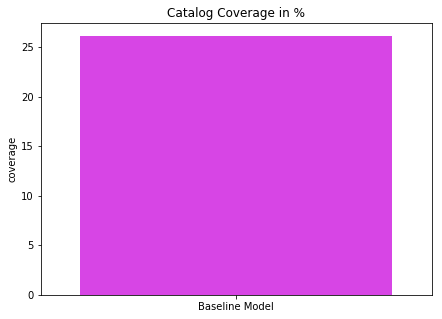

In [76]:
import recmetrics
import matplotlib.pyplot as plt
catalog = sample.movieId.unique().tolist()
baseline_predictions = test.baseline_predictions.values.tolist()
baseline_coverage = recmetrics.coverage(baseline_predictions, catalog)
fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(baseline_coverage, ['Baseline Model'])